In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
from sklearn.utils import shuffle

In [2]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [3]:
class_names = ["EMCI","LMCI","MCI","AD","CN"]
class_index=[0,1,2,3,4]

In [4]:
path=r"C:\Users\matrix\Desktop\Alzheimers-ADNI"

In [5]:
'''reading the images'''
data=dict()
# trainData=[]
# trainDataLables=[]
coo_matrix=[]
for name in class_names:
    images = [cv2.imread(file,cv2.COLOR_BGR2GRAY) for file in glob.glob(path+"\\train\\"+name+r'\*.jpg')]
    coo_matrix.append({name:len(images)})
    temp=[]
    for i in images:
        i=cv2.resize(i,(256, 256))
        temp.append(np.asarray(i).reshape(256, 256,1))
    data[name]=temp

In [6]:
'''balancing imbalanced data'''
print('before')
print(coo_matrix)
max_count=0
for name in class_names:
    if len(data[name])>max_count:
        max_count=len(data[name])
print(max_count)

for name in class_names:
    n=len(data[name])
    for t in range(n,max_count):
        rnd=data[name][random.randint(0, n)]
        data[name].append(rotate_image(rnd,random.randint(-10,10)))

coo_matrix=[]
for name in class_names:
    n=len(data[name])
    coo_matrix.append({name:n})

print('after')
print(coo_matrix)

before
[{'EMCI': 204}, {'LMCI': 61}, {'MCI': 196}, {'AD': 145}, {'CN': 486}]
486
after
[{'EMCI': 486}, {'LMCI': 486}, {'MCI': 486}, {'AD': 486}, {'CN': 486}]


In [7]:
trainData=[]
trainDataLables=[]
index=0
for name in class_names:
    for i in data[name]:
        trainData.append(i.flatten())
        trainDataLables.append(index)
    index+=1

trainData=np.array(trainData)
trainDataLables=np.asarray(trainDataLables)
trainData,trainDataLables=shuffle(trainData,trainDataLables)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(trainData,
                                                    trainDataLables,
                                                    test_size=.25,
                                                    random_state=1234123)

In [9]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [10]:
y_pred = model.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.3042763157894737


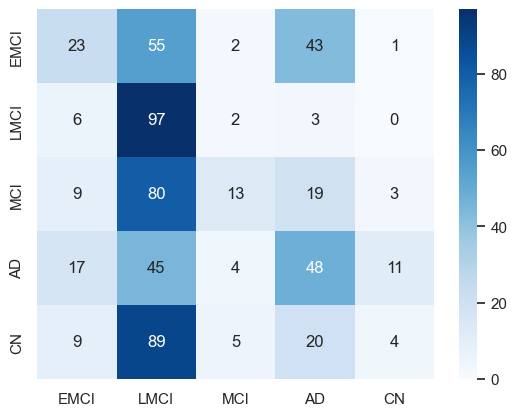

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set()
cf_matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix,annot=True,fmt='',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.show()

In [12]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(model,X_train, y_train,cv=10)

In [13]:
score

array([0.28961749, 0.30054645, 0.33516484, 0.35164835, 0.31318681,
       0.32417582, 0.31318681, 0.32967033, 0.31868132, 0.35164835])